In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from matplotlib import pyplot as plt
from sklearn import metrics

## Implementacja neuronu

In [88]:
from abc import ABC, abstractmethod
import logging
from numpy import exp

class Neuron(ABC):
    def __init__(self, weights: list) -> None:
        self.weights = weights
        self.output = 0
        self.deltas = []
        self.error = 0
        self.input = 0
        self.momentum = [0 for i in range(len(weights))]
        self.grads_squared = [0 for i in range(len(weights))]
        self.inputs = []
        if len(weights) < 2:
            logging.warning("Less than 2 weights. Are you sure?")
    
    def __repr__(self) -> str:
        return "%s(weights: %s, output: %s, error: %s)" % (self.name(), str(self.weights), str(self.output), str(self.error))
            
    @abstractmethod
    def evaluate(self, input: list):
        pass
    
    @abstractmethod
    def name(self) -> str:
        pass
    
    @abstractmethod
    def derivative(self, output: float) -> float:
        pass
    
    def add_one(l: list) -> list:
        tmp = [1]
        tmp.extend(l)
        return tmp
    
    def dot(a: list, b: list) -> float:
        tmp = min(len(a), len(b))
        return np.dot(a[:tmp], b[:tmp])

    
# pierwsza waga to waga biasu
class LinearNeuron(Neuron):
    def evaluate(self, input: list) -> float:
        self.inputs = Neuron.add_one(input)
        self.output = Neuron.dot(self.weights, self.inputs)
        self.input = self.output
        return self.output
    
    def name(self) -> str:
        return "LinearNeuron"
    
    def derivative(self, output: float) -> float:
        return 1.0
        

class SigmoidNeuron(Neuron):
    def evaluate(self, input: list) -> float:
        self.inputs = Neuron.add_one(input)
        x = Neuron.dot(self.weights, self.inputs)
        self.input = x
        self.output = math.e ** x / (1 + math.e ** x)
        return self.output
    
    def name(self) -> str:
        return "SigmoidNeuron"
    
    def derivative(self, output: float) -> float:
        return output * (1.0 - output)

class SoftmaxNeuron(Neuron):
    def evaluate(self, input: list):
        self.input = [input[i] * self.weights[i+1] + self.weights[0] for i in range(len(input))]
        e_x = np.exp(self.input - np.max(self.input))
        self.output = e_x / e_x.sum(axis=0)
        return list(self.output)
    
    def name(self) -> str:
        return "SoftmaxNeuron"
    
    def derivative(self, output):
        pass
    
class TanhNeuron(Neuron):
    def evaluate(self, input: list):
        self.inputs = Neuron.add_one(input)
        x = Neuron.dot(self.weights, self.inputs)
        self.input = x
        self.output = (math.e ** x - math.e ** (-x)) / (math.e ** x + math.e ** (-x))
        return self.output
    
    def name(self) -> str:
        return "TanhNeuron"
    
    def derivative(self, output: float) -> float:
        return 1 - output ** 2

class ReluNeuron(Neuron):
    def evaluate(self, input: list):
        self.inputs = Neuron.add_one(input)
        x = Neuron.dot(self.weights, self.inputs)
        self.input = x
        self.output = max(0, x)
        return self.output
    
    def name(self) -> str:
        return "ReLUNeuron"
    
    def derivative(self, output: float) -> float:
        return 1 if output >= 0 else 0
    
    
# tests

assert Neuron.dot([2,3], [5]) == 10
assert Neuron.dot([2,3], [4,5,6]) == 23

linearneuron = LinearNeuron([1,2,3])
assert linearneuron.evaluate([1,2,3]) == 9
assert linearneuron.evaluate([2,3]) == 14

sigmoidneuron = SigmoidNeuron([1, 2])
assert sigmoidneuron.evaluate([1]) == math.e ** 3 / (1 + math.e ** 3)

softmaxneuron = SoftmaxNeuron([0, 1, 1])
assert softmaxneuron.evaluate([1, 1]) == [0.5, 0.5]

print(linearneuron)
print(sigmoidneuron)
print(softmaxneuron)

LinearNeuron(weights: [1, 2, 3], output: 14, error: 0)
SigmoidNeuron(weights: [1, 2], output: 0.9525741268224333, error: 0)
SoftmaxNeuron(weights: [0, 1, 1], output: [0.5 0.5], error: 0)


## Implementacja warstwy

In [6]:
class Layer(ABC):
    def __init__(self) -> None:
        self.neurons = []
    
    @abstractmethod
    def __init__(self, num: int, weights: list) -> None:
        pass
        
    def addNeuron(self, neuron: Neuron) -> None:
        self.neurons.append(neuron)
        
    def evaluate(self, input: list) -> list:
        return [neuron.evaluate(input) for neuron in self.neurons]
    
    def __repr__(self) -> str:
        return "Layer(" + str(self.neurons) + ")"
    

class LinearLayer(Layer):
    def __init__(self, num: int, weights: list) -> None:
        assert len(weights) == num, "Invalid matrix dimension"
        self.neurons = [LinearNeuron(w) for w in weights]
    
class SigmoidLayer(Layer):
    def __init__(self, num: int, weights: list) -> None:
        assert len(weights) == num, "Invalid matrix dimension"
        self.neurons = [SigmoidNeuron(w) for w in weights]

class TanhLayer(Layer):
    def __init__(self, num: int, weights: list) -> None:
        assert len(weights) == num, "Invalid matrix dimension"
        self.neurons = [TanhNeuron(w) for w in weights]

class ReluLayer(Layer):
    def __init__(self, num: int, weights: list) -> None:
        assert len(weights) == num, "Invalid matrix dimension"
        self.neurons = [ReluNeuron(w) for w in weights]

class SoftmaxLayer(Layer):
    def __init__(self, num: int, weights: list) -> None:
        self.neurons = [SoftmaxNeuron(w) for w in weights]
    
    def evaluate(self, input):
        return self.neurons[0].evaluate(input)

# tests
layer1 = LinearLayer(1, [[1, 2]])
assert layer1.evaluate([5]) == [11]
layer1.addNeuron(LinearNeuron([2, 3]))
assert layer1.evaluate([5]) == [11, 17]

layer2 = LinearLayer(2, [[1,2], [2, 3]])
assert layer2.evaluate([5]) == [11, 17]
print(layer2)

layer3 = SoftmaxLayer(1, [[0, 1, 1]])
assert layer3.evaluate([1, 1]) == [0.5, 0.5]

Layer([LinearNeuron(weights: [1, 2], output: 11, error: 0), LinearNeuron(weights: [2, 3], output: 17, error: 0)])


## Implementacja sieci

In [62]:
from graphviz import Digraph
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import copy

class Network:
    def __init__(self) -> None:
        self.layers = []
        self.size = []
        self.s = None
    
    def __repr__(self) -> str:
        return "Network(" + "\n\t".join([str(layer) for layer in self.layers]) + ")"
    
    def __init__(self, layer_types: list, size: list, weights=None, gen_type="0|1", norm=True, cat=False) -> None:
        assert len(layer_types) == len(size) - 1, "Invalid matrix dimension"
        self.layers = []
        self.size = size
        self.norm = norm
        self.cat = cat
        for i, layer_type in enumerate(layer_types):
            if layer_type == "sigmoid":
                self.addLayerBack(SigmoidLayer(size[i + 1], weights[i] if weights else Network.generate(gen_type, (size[i + 1], size[i] + 1))))
            elif layer_type == "linear":
                self.addLayerBack(LinearLayer(size[i + 1], weights[i] if weights else Network.generate(gen_type, (size[i + 1], size[i] + 1))))
            elif layer_type == "relu":
                self.addLayerBack(ReluLayer(size[i + 1], weights[i] if weights else Network.generate(gen_type, (size[i + 1], size[i] + 1))))
            elif layer_type == "tanh":
                self.addLayerBack(TanhLayer(size[i + 1], weights[i] if weights else Network.generate(gen_type, (size[i + 1], size[i] + 1))))
            elif layer_type == "softmax":
                self.addLayerBack(SoftmaxLayer(size[i + 1], weights[i] if weights else Network.generate(gen_type, (size[i + 1], size[i] + 1))))
            else:
                logging.error("Invalid layer type")
    
    @staticmethod
    def batch_partition(list_in, n):
        l = copy.deepcopy(list_in)
        random.shuffle(l)
        return [l[(i * n):(i * n + n)] for i in range(int((len(l) + n - 1) / n))]
    
    @staticmethod
    def substr(a, b):
        return [a[i] - b[i] for i in range(len(a))]
        
    def generate(gen_type: str, n: tuple) -> np.array:
        if gen_type == "0|1":
            return np.random.uniform(0, 1, n)
        elif gen_type == "-1|1":
            return np.random.uniform(-1, 1, n)
        elif gen_type == "norm":
            return np.random.normal(0, 1, n)
        elif gen_type == "zero":
            return np.zeros(n)
        
    
    def addLayerBack(self, layer: Layer) -> None:
        self.layers.append(layer)
    
    def forward(self, x: list) -> list:
        input = x
        for layer in self.layers:
            out = []
            for val in input:
                tmp = layer.evaluate(val)
                out.append(tmp)
            input = out
        return input
    
    def predict(self, x):
        out = self.forward(x)
        if self.norm:
            out = self.s.inverse_transform(out)
        if self.cat:
            return [np.argmax(o) for o in out]
        return out
    
    def draw(self, prefix='', graph=None) -> None:
        g = Digraph(format='svg', name="neural network")
        if graph is not None:
            g = graph
        for idx, layer in enumerate(self.layers):
            current_id = idx + 1
            # create bias neuron
            bias_name = '%s_L%s_Bias' % (prefix, idx)
            g.node(bias_name)
            for n_i, neuron in enumerate(layer.neurons):
                # create dot for neuron
                neuron_name = '%s_L%s_N%s' % (prefix, current_id, n_i)
                g.node(neuron_name)
                # create dots and edges for parents
                for w_i, weight in enumerate(neuron.weights):
                    if w_i == 0:
                        g.edge(bias_name, neuron_name, label=format(weight, '.2f'))
                    else:
                        p_name = '%s_L%s_N%s' % (prefix, idx, w_i - 1)
                        g.node(p_name)
                        g.edge(p_name, neuron_name, label=format(weight, '.2f'))
        return g
            
    def backward_propagate_error(self, expected, l_rate):
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            
            if layer == self.layers[-1]:
                if type(layer) == SoftmaxLayer:
                    neuron = layer.neurons[0]
                    neuron.current_error = Network.substr(expected, neuron.output)
                    neuron.current_delta = neuron.current_error
                    # prawdopodobnie coś trzeba tu zmienić
                    for k in range(1, len(neuron.weights)):
                        neuron.deltas[k] += neuron.current_error[k-1]
                    neuron.deltas[0] += np.sum(neuron.current_delta)
                else:
                    for j, neuron in enumerate(layer.neurons):
                        neuron.error = (expected[j] - neuron.output)
                        neuron.current_delta = neuron.error * neuron.derivative(neuron.output)
                        neuron.current_error = (expected[j] - neuron.output)

                        for k in range(len(neuron.weights)):
                            neuron.deltas[k] += neuron.current_delta * neuron.inputs[k]
            else:
                next_layer = self.layers[i + 1]
                for j, neuron in enumerate(layer.neurons):
                    neuron.current_error = 0
                    neuron.current_delta = 0
                    for k, next_neuron in enumerate(next_layer.neurons):
                        neuron.current_error += next_neuron.weights[j+1] * (next_neuron.current_delta[j] if type(next_layer) == SoftmaxLayer else next_neuron.current_delta)
                    neuron.current_delta = neuron.current_error * neuron.derivative(neuron.output)
                    for k in range(len(neuron.weights)):
                        neuron.deltas[k] += neuron.current_delta * neuron.inputs[k]
    
    def update_weights(self, l_rate, size, momentum=False, m_lambda=0.1, rmsprop=False, rms_beta=0.9):
        for layer in self.layers:
            for neuron in layer.neurons:
                for i in range(len(neuron.weights)):
                    if momentum:
                        neuron.momentum[i] = neuron.momentum[i] * m_lambda + neuron.deltas[i] / size
                        neuron.weights[i] += neuron.momentum[i] * l_rate
                    elif rmsprop:
                        neuron.grads_squared[i] = rms_beta * neuron.grads_squared[i] + (1.0 - rms_beta) * (neuron.deltas[i] / size) ** 2
                        neuron.weights[i] += l_rate * (neuron.deltas[i] / size) / math.sqrt(neuron.grads_squared[i])
                    else:
                        neuron.weights[i] += neuron.deltas[i] * l_rate / size
    
    def clean_params(self):
        for idx, layer in enumerate(self.layers):
            for neuron in layer.neurons:
                neuron.output = 0
                neuron.deltas = [0 for i in range(len(neuron.weights))]
    
    def train_network(self, train_data: list, train_y: list, l_rate=1e-3, n_epoch=5, batch_size=None,
                     momentum=False, m_lambda=0.1, rmsprop=False, rms_beta=0.9) -> None:
        errors = []
        oks = []
        y_std = train_y
        if self.norm:
            self.s = StandardScaler()
            y_std = self.s.fit_transform(train_y)
        elif self.cat:
            max_y = np.max(y_std)
            y_std = [[1 if i == y[0] else 0 for i in range(max_y + 1)] for y in train_y]
        joined = [(train_data[i], y_std[i]) for i in range(len(train_y))]
        a = self.draw("null")
        for epoch in range(n_epoch):
            sum_error = 0
            ok = 0
            batches = Network.batch_partition(joined, batch_size) if batch_size else [joined]
            for batch_idx, batch in enumerate(batches):
                self.clean_params()
                for i, row in enumerate(batch):
                    x, expected = row
                    outputs = self.forward([x])
                    if self.cat:
                        for j in range(len(expected)):
                            sum_error += sum([(expected[j]-outputs[0][j])**2 for i in range(len(expected))])
                        if np.argmax(expected) == np.argmax(outputs[0]):
                            ok += 1
                    else:
                        sum_error += sum([(expected[i]-outputs[0][i])**2 for i in range(len(expected))])
                    self.backward_propagate_error(expected, l_rate)
                self.update_weights(l_rate, len(batch), momentum, m_lambda, rmsprop, rms_beta)
            if epoch % 100 == 99:
                a = self.draw(str(epoch), a)
            errors.append(sum_error)
            oks.append(ok)
#             print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
        return (a, errors, oks)
        

# tests
network = Network(["linear"], [1, 1], [[[1,2,3]]])
assert network.forward([[2,3]]) == [[14]]

network2 = Network(["linear"], [1, 2], [
        [[1,2], [2, 3]]
])
assert network2.forward([[5]]) == [[11, 17]]

In [8]:
test = Network(["sigmoid", "softmax"], [1, 4, 1], norm=False)
print(test.forward([[5], [0]]))
print(test.predict([[5], [0]]))
np.max([[1], [4]])

[[0.3247239515447047, 0.26750823922242284, 0.2366386670188978, 0.1711291422139747], [0.30363939824102326, 0.27029459230750563, 0.2378262005110988, 0.1882398089403722]]
[[0.3247239515447047, 0.26750823922242284, 0.2366386670188978, 0.1711291422139747], [0.30363939824102326, 0.27029459230750563, 0.2378262005110988, 0.1882398089403722]]


4

# Zbiór steps-large

In [11]:
train_df = pd.read_csv('./mio1/regression/steps-large-training.csv', index_col=0)
test_df = pd.read_csv('./mio1/regression/steps-large-test.csv', index_col=0)

### ReLU

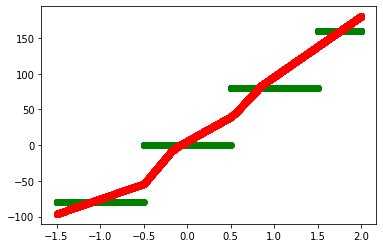

In [44]:
# 1 warstwa ukryta
np.random.seed(2137)
mlp = Network(["relu", "linear"], [1,10,1], norm=True)
_, relu_err, _ = mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, batch_size=32)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

/home/anna/.local/lib/python3.6/site-packages/ipykernel_launcher.py:130: RuntimeWarning: overflow encountered in double_scalars
/home/anna/.local/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: overflow encountered in double_scalars
/home/anna/.local/lib/python3.6/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in double_scalars


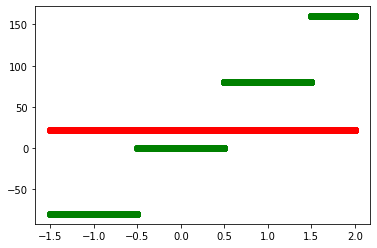

In [33]:
# 2 warstwy ukryte
relu_err1=relu_err
np.random.seed(2137)
mlp = Network(["relu", "relu", "linear"], [1,10,10,1], norm=False)
_, relu_err2, _ = mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, batch_size=32)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

/home/anna/.local/lib/python3.6/site-packages/ipykernel_launcher.py:130: RuntimeWarning: overflow encountered in double_scalars
/home/anna/.local/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: overflow encountered in double_scalars
/home/anna/.local/lib/python3.6/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in double_scalars


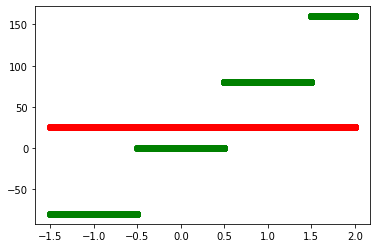

In [45]:
# 3 warstwy ukryte
np.random.seed(2137)
mlp = Network(["relu", "relu", "relu", "linear"], [1,10, 10, 4,1], norm=True)
_, relu_err3, _ = mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, batch_size=32)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Błąd

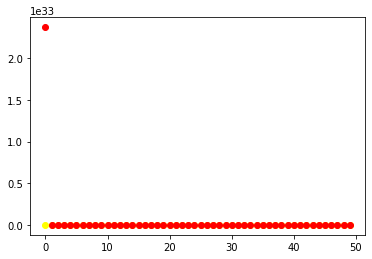

In [46]:
plt.scatter(range(len(relu_err1)), relu_err1, color='blue')
plt.scatter(range(len(relu_err2)), relu_err2, color='yellow')
plt.scatter(range(len(relu_err3)), relu_err3, color='red')
# plt.ylim(0, 11000)

### Tanh

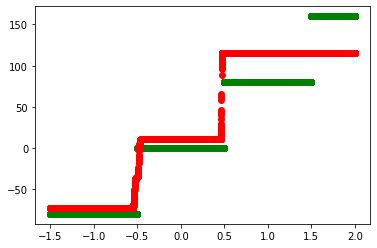

In [36]:
# 1 warstwa ukryta
np.random.seed(2137)
mlp = Network(["tanh", "linear"], [1,10,1], norm=False)
_, tanh_err1, _ = mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, batch_size=32)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

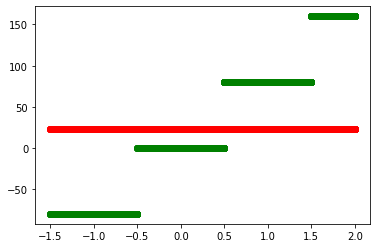

In [37]:
# 2 warstwy ukryte
np.random.seed(2137)
mlp = Network(["tanh", "tanh", "linear"], [1,10,10,1], norm=False)
_, tanh_err2, _ = mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, batch_size=32)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

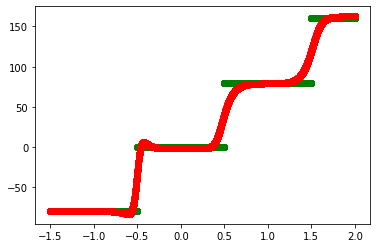

In [47]:
# 3 warstwy ukryte
np.random.seed(2137)
mlp = Network(["tanh", "tanh", "tanh", "linear"], [1,10, 10, 4,1], norm=True)
_, tanh_err3, _ = mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, batch_size=32)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Błąd

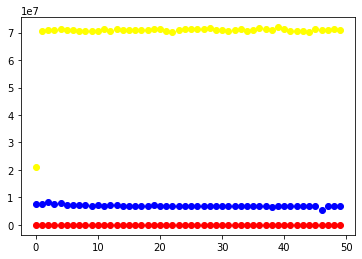

In [48]:
plt.scatter(range(len(tanh_err1)), tanh_err1, color='blue')
plt.scatter(range(len(tanh_err2)), tanh_err2, color='yellow')
plt.scatter(range(len(tanh_err3)), tanh_err3, color='red')
# plt.ylim(1000, 4000)

### Sigmoid

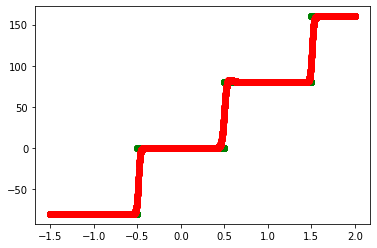

In [40]:
# 1 warstwa ukryta
np.random.seed(2137)
mlp = Network(["sigmoid", "linear"], [1,10,1], norm=False)
_, sigmoid_err1, _ = mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, batch_size=32)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

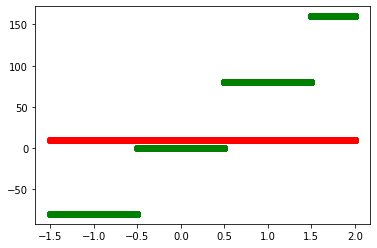

In [49]:
# 2 warstwy ukryte
np.random.seed(2137)
mlp = Network(["sigmoid", "sigmoid", "linear"], [1,10,10,1], norm=False)
_, sigmoid_err2, _ = mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=30, l_rate=0.1, batch_size=32)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

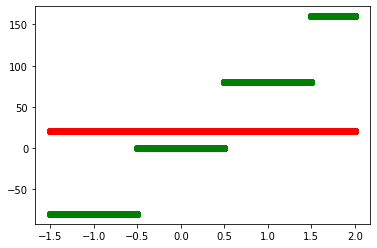

In [42]:
# 3 warstwy ukryte
np.random.seed(2137)
mlp = Network(["sigmoid", "sigmoid", "sigmoid", "linear"], [1,10, 10, 4,1], norm=False)
_, sigmoid_err3, _ = mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, batch_size=32)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Błąd

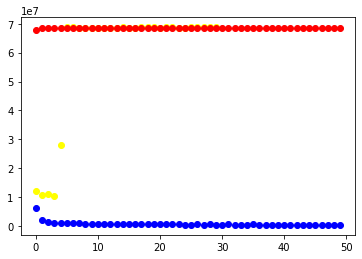

In [50]:
plt.scatter(range(len(sigmoid_err1)), sigmoid_err1, color='blue')
plt.scatter(range(len(sigmoid_err2)), sigmoid_err2, color='yellow')
plt.scatter(range(len(sigmoid_err3)), sigmoid_err3, color='red')
# plt.ylim(1000, 4000)

Wnioski:
- czasem dopasowanie zależy od tego, czy znormalizujemy `y`
- dalej najlepiej radzi sobie 1-warstwowy sigmoid (przy większej liczbie warstw jest tragicznie)
- tanh przy 3 warstwach radzi sobie bardzo dobrze, przy 1 też jest całkiem ok, przy 2 zachowuje się jak sigmoid :/
- ReLU sobie nie radzi

W kolejnych przykładach pozwolę sobie testować po jednej architekturze sieci, bo mój komputer nie należy do demonów prędkości i trzeba dość długo czekać na pojedynczy wynik (szczególnie przy dużej liczbie warstw)

# Zbiór multimodal-large

In [51]:
train_df = pd.read_csv('./mio1/regression/steps-large-training.csv', index_col=0)
test_df = pd.read_csv('./mio1/regression/steps-large-test.csv', index_col=0)

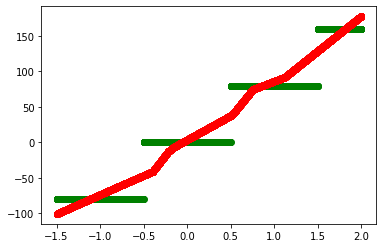

In [52]:
#relu
np.random.seed(2137)
mlp = Network(["relu", "linear"], [1,10,1], norm=True)
_, relu_err, _ = mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, batch_size=32)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

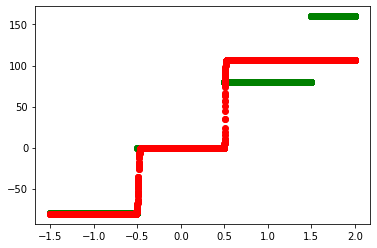

In [53]:
#tanh
np.random.seed(2137)
mlp = Network(["tanh", "linear"], [1,10,1], norm=False)
_, tanh_err, _ = mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, batch_size=32)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

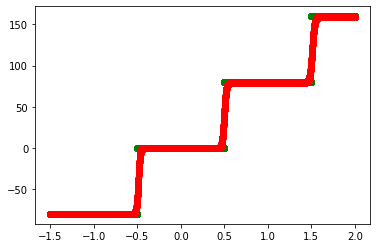

In [54]:
#sigmoid
np.random.seed(2137)
mlp = Network(["sigmoid", "linear"], [1,10,1], norm=False)
_, sigmoid_err, _ = mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, batch_size=32)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

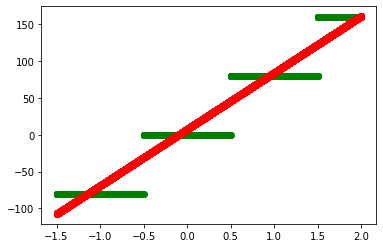

In [55]:
#linear
np.random.seed(2137)
mlp = Network(["linear", "linear"], [1,10,1], norm=True)
_, linear_err, _ = mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, batch_size=32)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Błąd

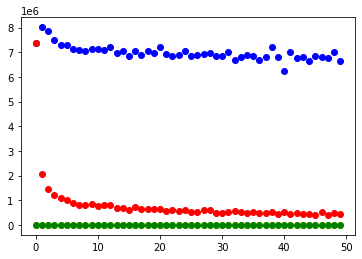

In [56]:
plt.scatter(range(len(tanh_err)), tanh_err, color='blue')
plt.scatter(range(len(relu_err)), relu_err, color='yellow')
plt.scatter(range(len(sigmoid_err)), sigmoid_err, color='red')
plt.scatter(range(len(linear_err)), linear_err, color='green')
# plt.ylim(1000, 4000)

(0.0, 2000.0)

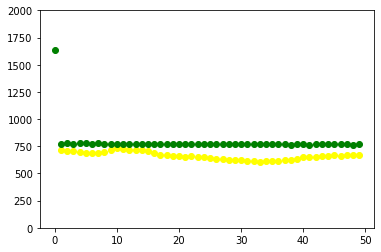

In [57]:
plt.scatter(range(len(tanh_err)), tanh_err, color='blue')
plt.scatter(range(len(relu_err)), relu_err, color='yellow')
plt.scatter(range(len(sigmoid_err)), sigmoid_err, color='red')
plt.scatter(range(len(linear_err)), linear_err, color='green')
plt.ylim(0, 2000)

Na podstawie wykresów dopasowania najlepiej dopasował się sigmoid i tanh, ale z wykresów błędów wynika, że najmniejszy błąd ma ReLU (liniowa nieco większy). Jest to w pierwszej chwili dość zaskakujące, ale wynika z przyjętej metryki. Kwadrat błędu bardziej karze jeden duży błąd niż wiele mniejszych błędów, więc wystarczy kilka wartości, które "zostały" na poprzednim schodku, żeby popsuć całościowy wynik.
# Zbiór rings5-regular

Text(0.5, 1.0, 'Train split')

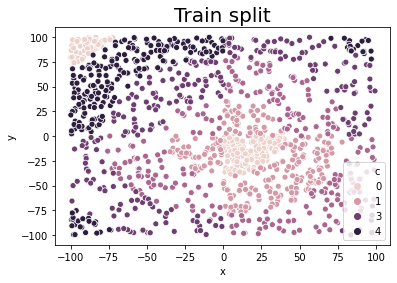

In [58]:
train_df = pd.read_csv('./mio1/classification/rings5-regular-training.csv')
test_df = pd.read_csv('./mio1/classification/rings5-regular-test.csv')
sns.scatterplot(x='x', y='y', hue='c', data=train_df)
plt.title('Train split', fontsize=20)

0.4288


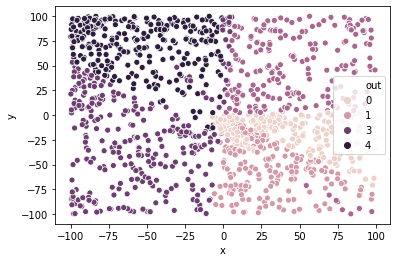

In [97]:
# tanh
np.random.seed(2137)
mpl = Network(["tanh", "linear", "softmax"], [2,10,5,1], cat=True, norm=False)
_, tanh_err, tanh_ok = mpl.train_network(train_df[['x', 'y']].to_numpy(), np.expand_dims(train_df['c'], 1), n_epoch=50, l_rate=0.01, batch_size=8)

y_pred = mpl.predict(train_df[['x', 'y']].to_numpy())
y_pred = np.squeeze(y_pred)
print(metrics.accuracy_score(y_pred, train_df['c']))
train_df['out'] = y_pred
sns.scatterplot(x='x', y='y', hue='out', data=train_df)

0.2424


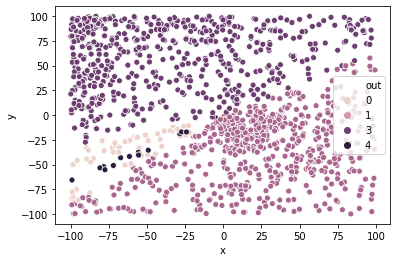

In [111]:
# relu
np.random.seed(2137)
mpl = Network(["relu", "softmax"], [2,5, 1], cat=True, norm=False)
_, relu_err, relu_ok = mpl.train_network(train_df[['x', 'y']].to_numpy(), np.expand_dims(train_df['c'], 1), n_epoch=10, l_rate=0.1, batch_size=8)

y_pred = mpl.predict(train_df[['x', 'y']].to_numpy())
y_pred = np.squeeze(y_pred)
print(metrics.accuracy_score(y_pred, train_df['c']))
train_df['out'] = y_pred
sns.scatterplot(x='x', y='y', hue='out', data=train_df)

0.216


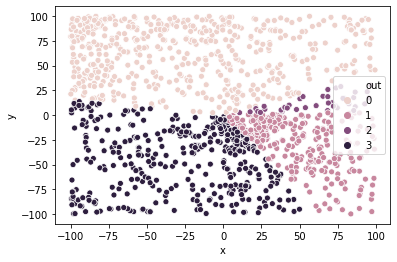

In [99]:
# linear
np.random.seed(2137)
mpl = Network(["linear", "softmax"], [2,5, 1], cat=True, norm=False)
_, linear_err, linear_ok = mpl.train_network(train_df[['x', 'y']].to_numpy(), np.expand_dims(train_df['c'], 1), n_epoch=10, l_rate=0.1, batch_size=8)

y_pred = mpl.predict(train_df[['x', 'y']].to_numpy())
y_pred = np.squeeze(y_pred)
print(metrics.accuracy_score(y_pred, train_df['c']))
train_df['out'] = y_pred
sns.scatterplot(x='x', y='y', hue='out', data=train_df)

0.4144


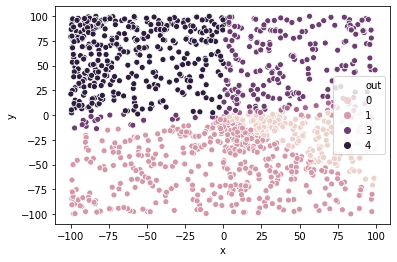

In [107]:
# sigmoid
np.random.seed(2137)
mpl = Network(["sigmoid", "sigmoid"], [2,10, 5], cat=True, norm=False)
_, sigmoid_err, sigmoid_ok = mpl.train_network(train_df[['x', 'y']].to_numpy(), np.expand_dims(train_df['c'], 1), n_epoch=50, l_rate=0.1, batch_size=8)

y_pred = mpl.predict(train_df[['x', 'y']].to_numpy())
y_pred = np.squeeze(y_pred)
print(metrics.accuracy_score(y_pred, train_df['c']))
train_df['out'] = y_pred
sns.scatterplot(x='x', y='y', hue='out', data=train_df)

##### Błąd

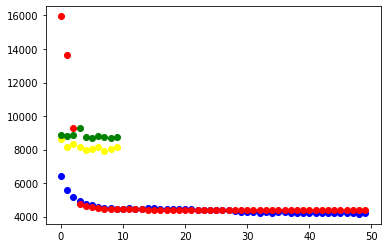

In [112]:
plt.scatter(range(len(tanh_ok)), tanh_err, color='blue')
plt.scatter(range(len(relu_ok)), relu_err, color='yellow')
plt.scatter(range(len(sigmoid_ok)), sigmoid_err, color='red')
plt.scatter(range(len(linear_ok)), linear_err, color='green')
# plt.ylim(1000, 4000)

##### Poprawne trafienia

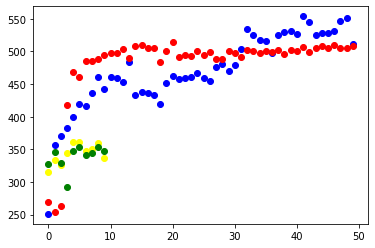

In [113]:
plt.scatter(range(len(tanh_ok)), tanh_ok, color='blue')
plt.scatter(range(len(relu_ok)), relu_ok, color='yellow')
plt.scatter(range(len(sigmoid_ok)), sigmoid_ok, color='red')
plt.scatter(range(len(linear_ok)), linear_ok, color='green')
# plt.ylim(1000, 4000)

Najlepiej poradził sobie tanh, sigmoid nieco gorzej, choć widać, że przy obecnych architekturach tanh mógł jeszcze podciągnąć wynik w następnych iteracjach, a sigmoid już osiągnął max możliwości. Liniową i ReLU szkoda komentować.
# Zbiór rings3-regular

Text(0.5, 1.0, 'Train split')

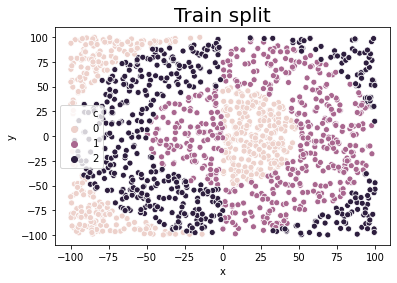

In [114]:
train_df = pd.read_csv('./mio1/classification/rings3-regular-training.csv')
test_df = pd.read_csv('./mio1/classification/rings3-regular-test.csv')
sns.scatterplot(x='x', y='y', hue='c', data=train_df)
plt.title('Train split', fontsize=20)

0.5053333333333333


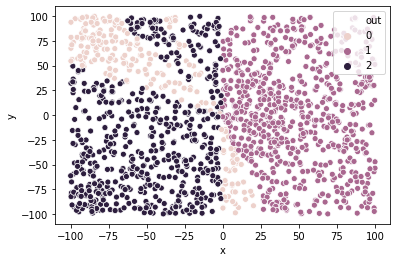

In [120]:
# tanh
np.random.seed(2137)
mpl = Network(["tanh", "linear", "softmax"], [2,10,3,1], cat=True, norm=False)
_, tanh_err, tanh_ok = mpl.train_network(train_df[['x', 'y']].to_numpy(), np.expand_dims(train_df['c'], 1), n_epoch=50, l_rate=0.01, batch_size=8)

y_pred = mpl.predict(train_df[['x', 'y']].to_numpy())
y_pred = np.squeeze(y_pred)
print(metrics.accuracy_score(y_pred, train_df['c']))
train_df['out'] = y_pred
sns.scatterplot(x='x', y='y', hue='out', data=train_df)

0.4066666666666667


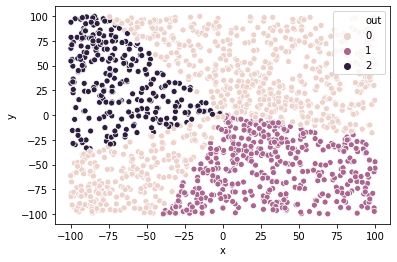

In [128]:
# relu
np.random.seed(2137)
mpl = Network(["relu", "softmax"], [2,3, 1], cat=True, norm=False)
_, relu_err, relu_ok = mpl.train_network(train_df[['x', 'y']].to_numpy(), np.expand_dims(train_df['c'], 1), n_epoch=50, l_rate=0.1, batch_size=8)

y_pred = mpl.predict(train_df[['x', 'y']].to_numpy())
y_pred = np.squeeze(y_pred)
print(metrics.accuracy_score(y_pred, train_df['c']))
train_df['out'] = y_pred
sns.scatterplot(x='x', y='y', hue='out', data=train_df)

0.404


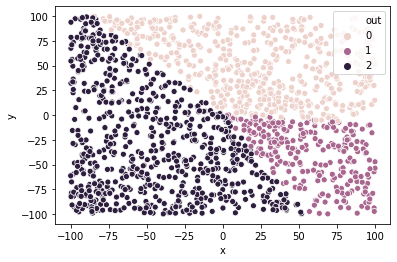

In [129]:
# linear
np.random.seed(2137)
mpl = Network(["linear", "softmax"], [2,3, 1], cat=True, norm=False)
_, linear_err, linear_ok = mpl.train_network(train_df[['x', 'y']].to_numpy(), np.expand_dims(train_df['c'], 1), n_epoch=50, l_rate=0.1, batch_size=8)

y_pred = mpl.predict(train_df[['x', 'y']].to_numpy())
y_pred = np.squeeze(y_pred)
print(metrics.accuracy_score(y_pred, train_df['c']))
train_df['out'] = y_pred
sns.scatterplot(x='x', y='y', hue='out', data=train_df)

0.49866666666666665


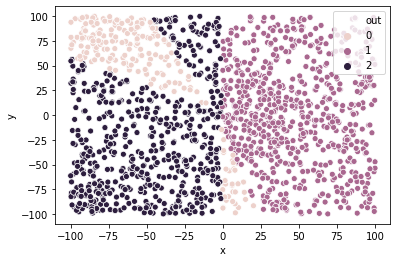

In [130]:
# sigmoid
np.random.seed(2137)
mpl = Network(["sigmoid", "sigmoid"], [2,10, 3], cat=True, norm=False)
_, sigmoid_err, sigmoid_ok = mpl.train_network(train_df[['x', 'y']].to_numpy(), np.expand_dims(train_df['c'], 1), n_epoch=50, l_rate=0.1, batch_size=8)

y_pred = mpl.predict(train_df[['x', 'y']].to_numpy())
y_pred = np.squeeze(y_pred)
print(metrics.accuracy_score(y_pred, train_df['c']))
train_df['out'] = y_pred
sns.scatterplot(x='x', y='y', hue='out', data=train_df)

##### Błąd

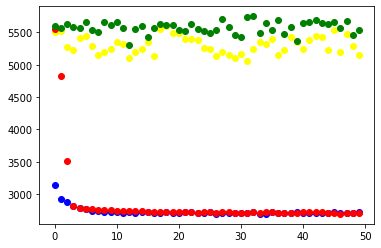

In [131]:
plt.scatter(range(len(tanh_ok)), tanh_err, color='blue')
plt.scatter(range(len(relu_ok)), relu_err, color='yellow')
plt.scatter(range(len(sigmoid_ok)), sigmoid_err, color='red')
plt.scatter(range(len(linear_ok)), linear_err, color='green')
# plt.ylim(1000, 4000)

##### Poprawne trafienia

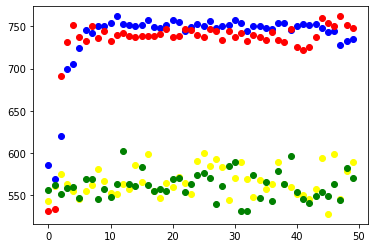

In [132]:
plt.scatter(range(len(tanh_ok)), tanh_ok, color='blue')
plt.scatter(range(len(relu_ok)), relu_ok, color='yellow')
plt.scatter(range(len(sigmoid_ok)), sigmoid_ok, color='red')
plt.scatter(range(len(linear_ok)), linear_ok, color='green')
# plt.ylim(1000, 4000)

Sytuacja podobna do poprzedniej. Sigmoid i tanh radzą sobie znacznie lepiej od funkcji liniowej i ReLU. Wiadomo - pewnie otrzymalibyśmy lepsze osiągi, gdybyśmy zmienili liczbę epok, może inny seed też by pomógł, ale przy tym prostym setupie funkcje nieliniowe wypadają po prostu lepiej.